In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from tqdm import tqdm


PATH_DATA = "/home/a.makarchuk@rit.va/Desktop/kaggle-CV-best11/dogs_vs_cats/data/"
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 250
EPOCHS = 15
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
TRAIN_RATIO = 0.9
SEED = 42

In [2]:
os.chdir(PATH_DATA)

submission_df = pd.read_csv(f"{PATH_DATA}sampleSubmission.csv")
list_train_imgs = os.listdir(f"{PATH_DATA}train")
list_test_imgs = os.listdir(f"{PATH_DATA}test1")

/home/a.makarchuk@rit.va/Desktop/kaggle-CV-best11/dogs_vs_cats/data//train/cat.4190.jpg


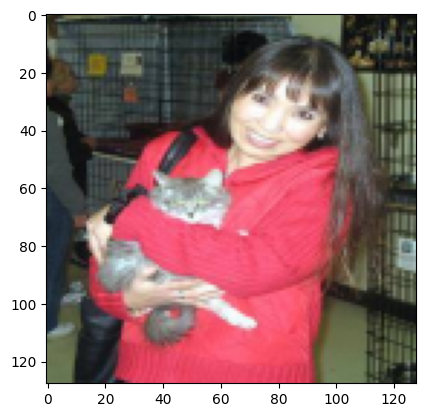

In [3]:
# SHOW DATA

rand_img_train_path = f"{PATH_DATA}/train/{random.choice(list_train_imgs)}"
img = plt.imread(rand_img_train_path)
img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

print(rand_img_train_path)

plt.imshow(img)
plt.show()

In [4]:
def load_and_transform_img(path_img, image_size):
    img_name = path_img.split("/")[-1]
    label = 1 if img_name.split(".")[0] == "dog" else 0
    img = plt.imread(path_img)
    img = cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    return torch.from_numpy(img).float(), torch.from_numpy(np.array(label)).float()


def generate_batch(list_imgs_path, batch_size):
    curr_id = 0
    while curr_id + batch_size < len(list_imgs_path):
        images_tensor_list = list()
        labels_tensor_list = list()
        for i in range(batch_size):
            img_tensor, label = load_and_transform_img(
                PATH_DATA + "train/" + list_imgs_path[curr_id + i], IMAGE_SIZE
            )
            img_tensor = img_tensor.permute(2, 0, 1)  # H, W, C -> C, H, W
            images_tensor_list.append(img_tensor)
            labels_tensor_list.append(label)
        yield torch.stack(images_tensor_list), torch.stack(labels_tensor_list).unsqueeze(-1)
        curr_id += batch_size

0.0


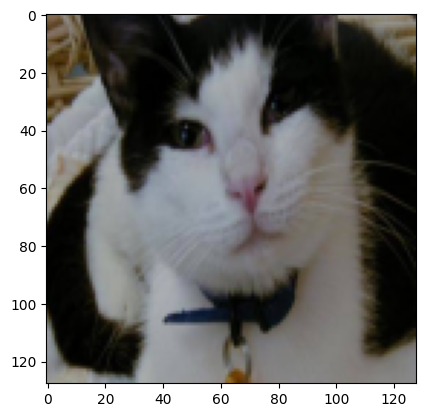

1.0


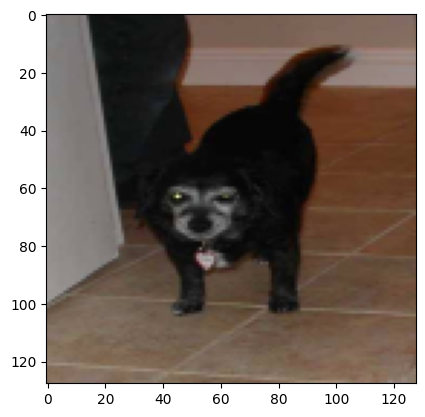

1.0


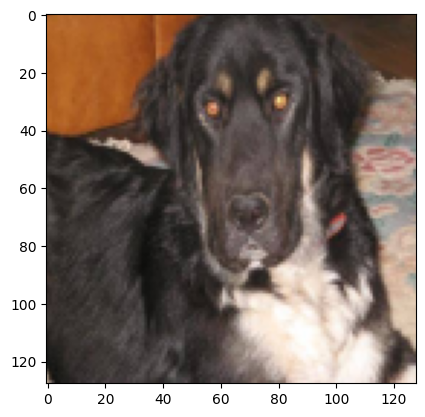

0.0


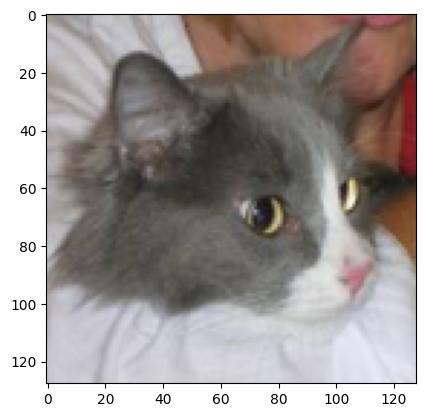

1.0


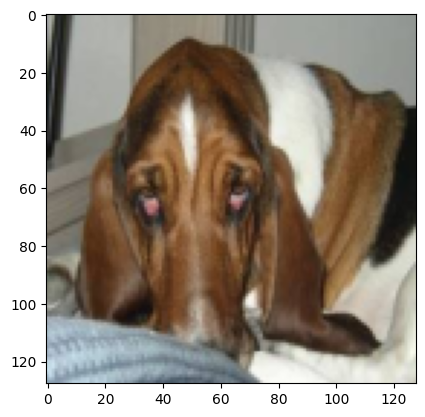

1.0


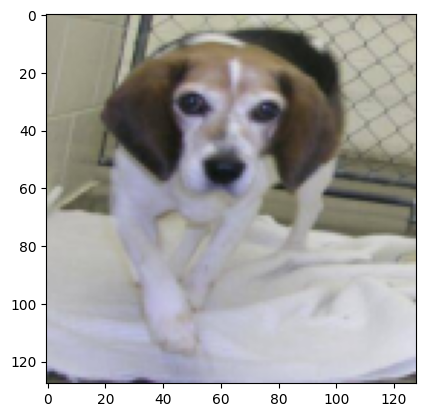

0.0


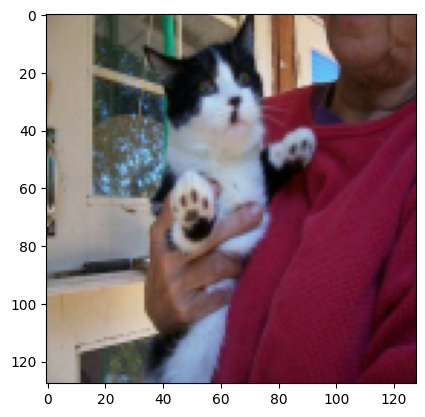

In [5]:
# CHECK LOADER


for i, (stacked_imgs, stacked_lbls) in enumerate(generate_batch(list_train_imgs, 1)):
    stacked_imgs = torch.stack([tensor_img.permute(1, 2, 0) for tensor_img in stacked_imgs])
    img = stacked_imgs.squeeze().numpy()
    label = stacked_lbls.squeeze().numpy()
    img = (img * 255).astype(int)
    print(label)
    plt.imshow(img)
    plt.show()
    if i > 5:
        break

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, image_size=IMAGE_SIZE):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.model(x)

In [7]:
model = NeuralNetwork().to(DEVICE)
sigmoid = nn.Sigmoid()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)

list_imgs = list_train_imgs[:]
random.shuffle(list_imgs)
list_train_imgs = list_imgs[: int(len(list_imgs) * TRAIN_RATIO)]
list_val_imgs = list_imgs[int(len(list_imgs) * TRAIN_RATIO) :]

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    model.train()
    for idx, (batch_imgs, labels) in tqdm(
        enumerate(generate_batch(list_train_imgs, BATCH_SIZE)),
        total=len(list_train_imgs) // BATCH_SIZE,
    ):
        batch_imgs = batch_imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = model(batch_imgs)

        loss = loss_fn(sigmoid(logits), labels)
        loss.backward()
        opt.step()
        opt.zero_grad()

        predicted_probs = sigmoid(logits).detach().cpu().numpy()
        predicted_labels = (predicted_probs > 0.5).astype(float)

        if idx % 50 == 0:
            print(
                f"Train F1-score: {f1_score(labels.detach().cpu().numpy(), predicted_labels):.4f} Train Loss: {loss:.4f}"
            )

    model.eval()
    val_preds = []
    val_labels = []
    val_losses = []
    with torch.no_grad():
        for batch_imgs, labels in tqdm(
            generate_batch(list_val_imgs, BATCH_SIZE), total=len(list_val_imgs) // BATCH_SIZE
        ):
            batch_imgs = batch_imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(batch_imgs)
            val_losses.append(loss_fn(sigmoid(logits), labels).detach().cpu().numpy())
            predicted_probs = sigmoid(logits).detach().cpu().numpy()
            predicted_labels = (predicted_probs > 0.5).astype(float)

            val_preds.extend(predicted_labels)
            val_labels.extend(labels.detach().cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds)
    print(f"Validation F1-score: {val_f1:.4f} Validation Loss: {np.mean(val_losses):.4f}")

Epoch 1/5


  0%|▌                                                                                                   | 1/200 [00:00<02:18,  1.44it/s]

Train F1-score: 0.4423 Train Loss: 0.6965


 26%|█████████████████████████▏                                                                         | 51/200 [00:32<01:37,  1.52it/s]

Train F1-score: 0.4878 Train Loss: 0.6467


 50%|█████████████████████████████████████████████████▍                                                | 101/200 [01:02<01:00,  1.63it/s]

Train F1-score: 0.6452 Train Loss: 0.6513


 76%|█████████████████████████████████████████████████████████████████████████▉                        | 151/200 [01:34<00:30,  1.62it/s]

Train F1-score: 0.6170 Train Loss: 0.6362


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:16<00:00,  2.99it/s]


Validation F1-score: 0.6343 Validation Loss: 0.6371
Epoch 2/5


  0%|▌                                                                                                   | 1/200 [00:00<01:42,  1.94it/s]

Train F1-score: 0.6667 Train Loss: 0.5905


 26%|█████████████████████████▏                                                                         | 51/200 [00:28<01:25,  1.74it/s]

Train F1-score: 0.5495 Train Loss: 0.6249


 50%|█████████████████████████████████████████████████▍                                                | 101/200 [00:56<00:54,  1.81it/s]

Train F1-score: 0.5895 Train Loss: 0.6368


 76%|█████████████████████████████████████████████████████████████████████████▉                        | 151/200 [01:23<00:25,  1.90it/s]

Train F1-score: 0.6316 Train Loss: 0.6178


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:14<00:00,  3.33it/s]


Validation F1-score: 0.6509 Validation Loss: 0.6191
Epoch 3/5


  0%|▌                                                                                                   | 1/200 [00:00<01:55,  1.72it/s]

Train F1-score: 0.7356 Train Loss: 0.5557


 26%|█████████████████████████▏                                                                         | 51/200 [00:28<01:15,  1.98it/s]

Train F1-score: 0.6154 Train Loss: 0.6115


 50%|█████████████████████████████████████████████████▍                                                | 101/200 [00:55<00:55,  1.79it/s]

Train F1-score: 0.6535 Train Loss: 0.6194


 76%|█████████████████████████████████████████████████████████████████████████▉                        | 151/200 [01:22<00:28,  1.75it/s]

Train F1-score: 0.6667 Train Loss: 0.6017


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:14<00:00,  3.32it/s]


Validation F1-score: 0.6762 Validation Loss: 0.6035
Epoch 4/5


  0%|▌                                                                                                   | 1/200 [00:00<01:41,  1.96it/s]

Train F1-score: 0.7500 Train Loss: 0.5314


 26%|█████████████████████████▏                                                                         | 51/200 [00:26<01:20,  1.86it/s]

Train F1-score: 0.6667 Train Loss: 0.5962


 50%|█████████████████████████████████████████████████▍                                                | 101/200 [00:52<00:50,  1.96it/s]

Train F1-score: 0.6931 Train Loss: 0.5977


 76%|█████████████████████████████████████████████████████████████████████████▉                        | 151/200 [01:17<00:25,  1.93it/s]

Train F1-score: 0.7000 Train Loss: 0.5833


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:14<00:00,  3.28it/s]


Validation F1-score: 0.6915 Validation Loss: 0.5906
Epoch 5/5


  0%|▌                                                                                                   | 1/200 [00:00<01:53,  1.76it/s]

Train F1-score: 0.7416 Train Loss: 0.5101


 26%|█████████████████████████▏                                                                         | 51/200 [00:26<01:15,  1.97it/s]

Train F1-score: 0.6452 Train Loss: 0.5829


 50%|█████████████████████████████████████████████████▍                                                | 101/200 [00:53<00:56,  1.74it/s]

Train F1-score: 0.6990 Train Loss: 0.5778


 76%|█████████████████████████████████████████████████████████████████████████▉                        | 151/200 [01:21<00:24,  2.00it/s]

Train F1-score: 0.6869 Train Loss: 0.5667


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:16<00:00,  2.95it/s]

Validation F1-score: 0.6957 Validation Loss: 0.5798


In [17]:
model.eval()
test_preds = pd.DataFrame(
    {
        "id": [int(path_img.split(".")[0]) for path_img in list_test_imgs],
        "label": [
            sigmoid(
                model(
                    torch.from_numpy(
                        cv2.imread(f"{PATH_DATA}test1/{path_img}").astype(np.float32) / 255.0
                    )
                    .permute(2, 0, 1)
                    .unsqueeze(0)
                    .to(DEVICE)
                )
            ).item()
            for path_img in list_test_imgs
        ],
    }
)

test_preds = test_preds.sort_values("id").reset_index(drop=True)

In [ ]:
test_preds

In [ ]:
test_preds.to_csv("base_FCONV_from_scratch.csv", index=False)

/home/a.makarchuk@rit.va/Desktop/kaggle-CV-best11/dogs_vs_cats/data/test1/5543.jpg
0.21893984079360962


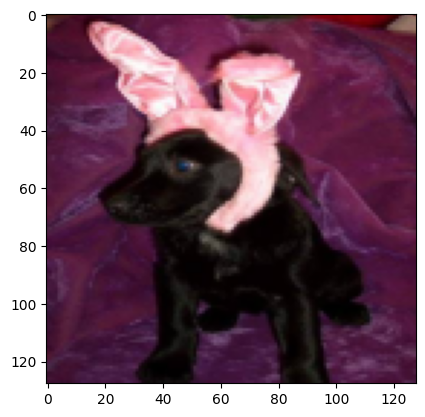

In [16]:
# CHECK PREDICTS ON TEST

rand_img_train_path = f'{PATH_DATA}test1/{".".join(random.choice(list_train_imgs).split(".")[1:])}'
img = plt.imread(rand_img_train_path)
img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

print(rand_img_train_path)

plt.imshow(img)
print(
    sigmoid(
        model(
            (torch.from_numpy(img.astype(np.float32)) / 255.0)
            .permute(2, 0, 1)
            .unsqueeze(0)
            .to(DEVICE)
        )
    ).item()
)
plt.show()